## Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.optimizers import RMSprop, Adam
import math
from matplotlib import pyplot as plt
import numpy as np

2024-03-13 19:50:03.797494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Modelo para resolver la ecuación diferencial 

#### $$y^{''} + y = 0$$ con las condiciones $$y(0)= 1$$ y $$y'(0)=-\frac{1}{2}$$ 

In [74]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)
         x2_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x1_0=0

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 tape2.watch(x2_o)
                 with tf.GradientTape(persistent=True) as tape3:
                    tape3.watch(x)
                    tape3.watch(x2_o)
                    y_pred = self(x, training=True)
                    y_pred_o = self(x2_o, training=True)
                 dy = tape3.gradient(y_pred,x)
                 dy_o = tape3.gradient(y_pred_o,x2_o)

             ddy = tape2.gradient(dy, x)#segunda derivada del modelo con respecto a entradas x
             x1_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x1_0=0
             y1_o = self(x1_o,training=True) #valor del modelo en en x1_0
             eq = ddy + y_pred #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeño
             ic1 = 1. #valor que queremos para la condicion inicial o el modelo en x_0
             ic2 = -0.5
             loss = self.mse(0., eq) + self.mse(y1_o,ic1) + self.mse(dy_o,ic2)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación del modelo

In [75]:
model = ODEsolver()
model.add(Dense(200, activation='tanh', input_shape=(1,)))
model.add(Dense(300, activation='tanh'))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "od_esolver_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 200)               400       
                                                                 
 dense_31 (Dense)            (None, 300)               60300     
                                                                 
 dense_32 (Dense)            (None, 1)                 301       
                                                                 
Total params: 61,001
Trainable params: 61,001
Non-trainable params: 0
_________________________________________________________________


# Graficando

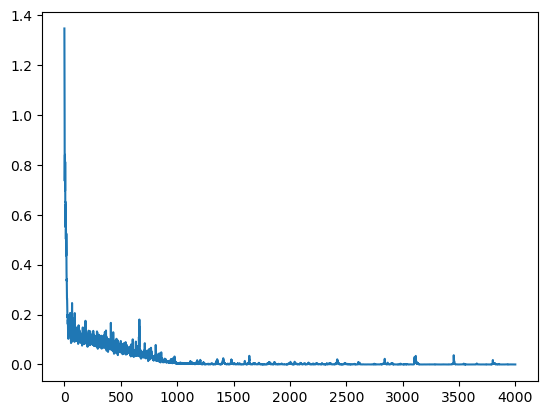

In [76]:
model.compile(Adam(learning_rate=0.001),metrics=['loss'])
x=tf.linspace(-5,5,100)
history = model.fit(x,epochs=4000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 10ms/step


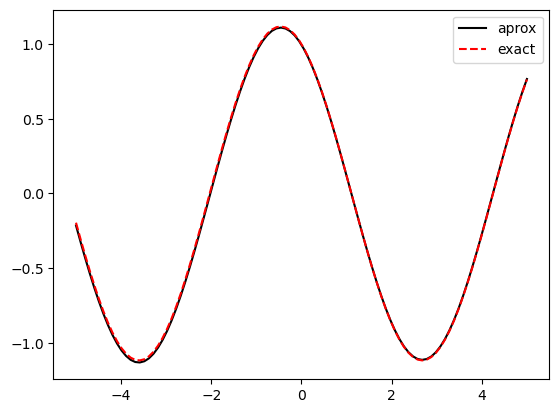

In [77]:
x_testv = tf.linspace(-5,5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox", color='black')
plt.plot(x_testv, tf.math.cos(x) - (1./2.)*tf.math.sin(x),label="exact", color='red', linestyle='--')
plt.legend()
plt.show()